# Assessing existence: a first step in isolating the complex
In this notebook we will take a look at what it means to "assess existence" (or, perhaps more precisely "assess causality") in IIT. Following the introduction given of the [postulate](link) and on the [unfolding page](link), we will explore the following concepts:

1) Basic properties of the transition probability matrix (TPM)
2) What is meant by conditional independence of the units?
3) How to obtain constrained and unconstrained probabilities from the TPM
4) how to compute causal informativeness
5) how we can use the causal informativeness to assess existence in its most basic form

Let's go!

---
 
<img src="https://github.com/bjorneju/IIT_wiki_tutorial/blob/main/notebooks/figures/Panel_1.jpg?raw=true" width=500/>

Just as a reminder, this is the example system we will work with: it is constituted of three simple, binary units (A, B, and C), each one of which is activated according to a sigmoidal activation function. Its connectivity, together with the units own function, determines the subtrate's TPM---the basis for the mathematical formalism we use in IIT.

## Import packages
The first thing to do is import the packages we will need

In [1]:
import pyphi
from tutorial_functions import visualization as viz
from tutorial_functions import utils
import numpy as np

%load_ext blackcellmagic
%load_ext autoreload

%matplotlib inline
%autoreload 2

## Create the substrate
Next, let's use the built-in functionality of pyphi to create the substrate from figure 1 of [the IIT 4.0 paper](https://arxiv.org/abs/2212.14787)

In [2]:
# give names to the units
node_labels = ["A","B","C"]

# set the strength of connectivity between units
connectivity = np.array(
    [
        [-.2,0.7,0.2],
        [0.7,-.2,0.0],
        [0.0,-.8,0.2]        
    ]
)

# set the level of determinism for the units' activation function 
determinism = 4

# build the network
substrate = pyphi.network_generator.build_network(
    [pyphi.network_generator.ising.probability]*len(node_labels),
    connectivity,
    temperature=1/determinism,
    node_labels=node_labels
)

substrate.node_labels

NodeLabels(('A', 'B', 'C'))

## The question: Does this substrate satisfy the 0th postulate? 
0th postulate of IIT: The substrate of consciousness must have cause–effect power.

To answer this question we must check whether the substrate can both take and make a difference (i.e. whether it has both cause and effect power in at least one of its potential states). 

In [3]:
utils.assess_existence(substrate)

The substrate ABC satisfies existence! 
Its units can both take and make makes a difference.


---
To understand what goes into assessing existence, we will explore the five points mentioned above one by one. 

## 1) Basic properties of the transition probability matrix (TPM)

Let's start by simply inspecting the TPM of the substrate and explore its properties from there

In [4]:
# visualize the TPM in its state-by-state form
viz.substrate_state_by_state(substrate)

,,A,0,1,0,1,0,1,0,1
,,B,0,0,1,1,0,0,1,1
,,C,0,0,0,0,1,1,1,1
A,B,C,,,,,,,,
0,0,0,0.17,0.02,0.56,0.08,0.03,0.00,0.11,0.02
1,0,0,0.00,0.00,0.49,0.01,0.00,0.00,0.49,0.01
0,1,0,0.01,0.48,0.01,0.33,0.00,0.10,0.00,0.07
1,1,0,0.00,0.00,0.06,0.44,0.00,0.00,0.06,0.44
0,0,1,0.44,0.06,0.00,0.00,0.44,0.06,0.00,0.00
1,0,1,0.07,0.00,0.10,0.00,0.33,0.01,0.48,0.01
0,1,1,0.01,0.49,0.00,0.00,0.01,0.49,0.00,0.00



Each of these numbers indicate the probability that the substrate will transition from an input state (left) to an output state (top).
For example, we can see that the substrate has about a 50% probability of transitioning to (0,1,0) if it was in state (1,0,0).

What is its probability of transitioning from input state (1,1,0) to output state (1,1,1)?

---

One way to answer such questions is by highlighting the relevant probabilities

In [5]:
# select state transition to highlight
input_state = (1,1,0)
output_state = (1,1,1)

# Get the state-by-state TPM
TPM = utils.state_by_state_tpm(substrate)

# visualize it with the state transition probability highlighted
viz.highlight_transition_probability(TPM,input_state,output_state)

,,A,0,1,0,1,0,1,0,1
,,B,0,0,1,1,0,0,1,1
,,C,0,0,0,0,1,1,1,1
A,B,C,,,,,,,,
0,0,0,0.169634,0.022957,0.563205,0.076222,0.034249,0.004635,0.113709,0.015389
1,0,0,0.000541,0.000015,0.486160,0.013284,0.000541,0.000015,0.486160,0.013284
0,1,0,0.013248,0.484871,0.008881,0.325019,0.002675,0.097894,0.001793,0.065620
1,1,0,0.000327,0.002416,0.059274,0.437982,0.000327,0.002416,0.059274,0.437982
0,0,1,0.437982,0.059274,0.002416,0.000327,0.437982,0.059274,0.002416,0.000327
1,0,1,0.065620,0.001793,0.097894,0.002675,0.325019,0.008881,0.484871,0.013248
0,1,1,0.013284,0.486160,0.000015,0.000541,0.013284,0.486160,0.000015,0.000541


The probability of transitioning from input state (1,1,0) to output state (1,1,1) is approximately 0.44, or 44%.

We can also get at this conditional probability, by indexing into TPM directly.

In [6]:
# Get probability 
P = TPM[output_state][input_state]

print('Probability of transitioning from {} to {} is {}'.format(
    input_state,output_state,P.round(3)
))

Probability of transitioning from (1, 1, 0) to (1, 1, 1) is 0.438


Given a particular input state, the output state it might bring about is rarely fully deterministic (the probability is rarely exactly 1). This just means that several output states are available from the given input state, and that the output state that actually occurs is not fully determined by the input state.

Just to get an overview of the situation, it might be useful to see the way the probabilities are distributed across the possible output states.
This can easily be visualized by a histogram:

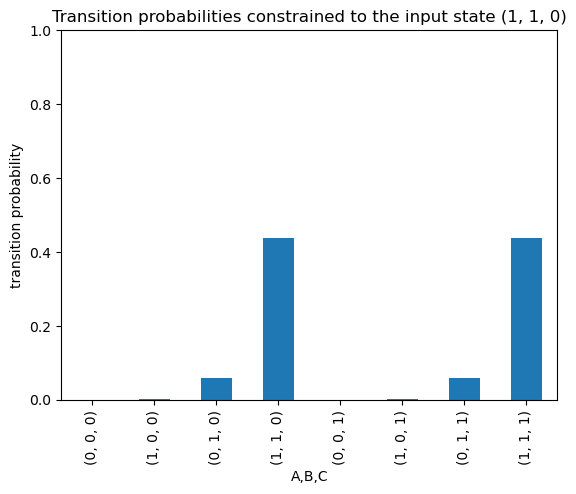

In [7]:
input_state = (1,1,0)
viz.constrained_repertoire(substrate, input_state);

As you may see from the name of the function above, we often refer to the conditional probabilities in the TPM as the *constrained probabilities*. This is because they indicate the probability of seeing a particular output state next, given (or constrained to the knowledge) that the input state was what it was. This is to contrast it to the *un*constrained probabilities (which we will see later), that tell us about the probabilities of observing some outputstate independently of what the input state was.  

You may notice that the TPM is normalized such that each row sums to exactly 1. This is because the substrate will necessarily transition to *some* state, whatever its starting point (input state) might be. In other words, the substrate has a 100% chance of transitioning to one of its available output states. 

In [8]:
TPM.sum(axis=1)

A  B  C
0  0  0    1.0
1  0  0    1.0
0  1  0    1.0
1  1  0    1.0
0  0  1    1.0
1  0  1    1.0
0  1  1    1.0
1  1  1    1.0
dtype: float64

Here is the description of what a TPM is from the latest academic publication (Albantakis et al 2023).
> The TPM, which forms the starting point of IIT’s analysis, serves as an overall
description of a system’s cause–effect power: what is the probability that the system
will transition into each of its possible states upon an intervention that initializes it into
every possible state?

Feel free to explore it!

## 2) What is meant by conditional independence of the units?

While it might seem natural to look at this square "state-by-state" representation of the TPM, it hides a crucial fact about substrates in IIT: their units are conditionally independent! This means that, given the knowledge of what the input state of a substrate was, the output state of each unit is *independent* of the output state of the other units. 

Lets explore this fact with the inbuilt functionality of pyphi.

In [9]:
# set an input state for the substrate
input_state = (1,0,0)

# print the values stored in the pyphi tpm when we provide it with the input state
substrate.tpm[input_state]

ExplicitTPM([0.02659699 0.99888746 0.5       ])

Rather than a single probability for each possible output state (as we obtained above), this return an array of three numbers. 

These numbers just represent the probability of each of the three units (A, B and C) being ON in the output state. 
For example, if you choose the input state (1,0,0,), you will see that unit A (represented by the first number) is almost guaranteed to be OFF (because P(ON)=0.027, and P(OFF)=1-P(ON)). 
Similarly, unit B is almost guaranteed to be ON, and unit C is completely undetermined: it is 50/50 whether it turns ON or OFF. 
Thus, we can see that all three units are indeterministic (none of the values are exactly 0 or 1). 
And while it is not explicit in the numbers, there is no dependence between what state unit A (first number) happens to take on and which state the other units will take on; each unit will just update according to their own probability. 

---

Furthermore, you might notice that we can derive the exact probabilities we saw in the previous "state-by-state"-representation of the TPM by using multiplication of these probabilities. For example, the probability of the substrate's overall output state is ON, ON, ON is just equal to the product of the three probabilities above. This is a direct consequence of the conditional independence.

In [10]:
input_state = (1,0,1)
output_state = (1,1,1)
P_from_units = utils.substrate_probability_from_unit_probabilities(substrate,input_state, output_state)
P_from_units

0.01324847157151889

Just to make what happens here explicit: we just take the product of the individual unit's probabilities. There is no interaction (dependence) between the outcome states of the subtrate units, given that their input state are determined

In [11]:
P = substrate.tpm[input_state]
P_A_on = P[0]
P_B_on = P[1]
P_C_on = P[2]

P_ABC_on_on_on = P_A_on*P_B_on*P_C_on
P_ABC_on_on_on

0.01324847157151889

Compare this probability to the one we have from the state-by-state TPM

In [12]:

viz.highlight_transition_probability(TPM,input_state,output_state)

,,A,0,1,0,1,0,1,0,1
,,B,0,0,1,1,0,0,1,1
,,C,0,0,0,0,1,1,1,1
A,B,C,,,,,,,,
0,0,0,0.169634,0.022957,0.563205,0.076222,0.034249,0.004635,0.113709,0.015389
1,0,0,0.000541,0.000015,0.486160,0.013284,0.000541,0.000015,0.486160,0.013284
0,1,0,0.013248,0.484871,0.008881,0.325019,0.002675,0.097894,0.001793,0.065620
1,1,0,0.000327,0.002416,0.059274,0.437982,0.000327,0.002416,0.059274,0.437982
0,0,1,0.437982,0.059274,0.002416,0.000327,0.437982,0.059274,0.002416,0.000327
1,0,1,0.065620,0.001793,0.097894,0.002675,0.325019,0.008881,0.484871,0.013248
0,1,1,0.013284,0.486160,0.000015,0.000541,0.013284,0.486160,0.000015,0.000541


They are identical! (except for some rounding issues in the visualization)

This is true for any combination of input and output states: the the conditional probabilities in the state-by-state (square) TPM are always found by taking the product of probabilities from the state-by-node TPM. try it out!

In [13]:

# choose some input and output states
input_state = (1,1,0)
output_state = (1,1,1)

# compute probaility of the ooutput state happening from both TPM representations
P_from_units = utils.substrate_probability_from_unit_probabilities(substrate, input_state, output_state)
P_from_statebystate = TPM[output_state][input_state]

# check if they are the same
print('P from units: {}, P from state-by-state: {}'.format(P_from_units.round(3),P_from_statebystate.round(3)))
print('Are they equal?: {}'.format(P_from_units == P_from_statebystate))

P from units: 0.438, P from state-by-state: 0.438
Are they equal?: True


---

How would you compute the probability of the output state (1,0,0) given the input state (0,1,1) using the substrate.tpm?

---

In fact, it might be best to think of the TPM primarily in its state-by-node form. 
As that makes it easier to remember that the units are conditionally independent. 

In [14]:
viz.substrate_state_by_node(substrate)

,,,A ON,B ON,C ON
A,B,C,,,
0,0,0,0.12,0.77,0.17
1,0,0,0.03,1.00,0.50
0,1,0,0.97,0.40,0.17
1,1,0,0.88,0.99,0.50
0,0,1,0.12,0.01,0.50
1,0,1,0.03,0.60,0.83
0,1,1,0.97,0.00,0.50
1,1,1,0.88,0.23,0.83


Each column in this TPM shows the probability of the corresponding (binary) unit turning *ON*. In fact, we might just as well consider each column independently as a "unit TPM" for its corresponding unit.  

In [15]:
viz.unit_state_by_node(substrate,'B')

,,,B ON
A,B,C,
0,0,0,0.77
1,0,0,1.00
0,1,0,0.40
1,1,0,0.99
0,0,1,0.01
1,0,1,0.60
0,1,1,0.00
1,1,1,0.23


The perceptive reader might have spotted that units A and C seem to be behaving a bit strangely: the values in their unit TPMs seem to repeat in a structured manner.

In [16]:
viz.unit_state_by_node(substrate,'C')

,,,C ON
A,B,C,
0,0,0,0.17
1,0,0,0.50
0,1,0,0.17
1,1,0,0.50
0,0,1,0.50
1,0,1,0.83
0,1,1,0.50
1,1,1,0.83


This is because it only receives inputs from two out of the three units in the substrate.

In [17]:
unit = 'C'
inputs = utils.possible_inputs(substrate, unit)
print('Unit {} appears to receive inputs from the following units: {}'.format(unit,inputs))

Unit C appears to receive inputs from the following units: ['A', 'C']


Still, it is useful to keep the full set of input states in the TPM, for completeness sake. 
But you are encouraged to explore what the unit TPM's might look like (and how to obtain it) if we only consider the inputs that really make a difference to its output state! 
Have a go at figuring out how you can reduce the TPM such that it only has input states that matter (make a difference) to the C :)

In any case, the assumption of conditional independence lets us obtain the probability of any substrate output state, by multiplying together the probabilities of the relevant outputs states of each individual unit in the substrate.

---

Let's move on to the next section.

## 3) How to obtain constrained and unconstrained probabilities from the TPM

We mentioned above that the raw probabilities in the TPM are *constrained* probabilities. 
They are called this because they are conditional on a particular state, and in that sense they are constrained by the input state. 

In contrast, it is also possible to find the *un*constrained probabilities. That is, the probabilities that a certain output state appears, *independently* of what the input state was. 

---

For example, you might ask, what is the probability of unit C turning ON, regardless of its input state?

In [18]:
unit = 'C'
output_state = 0
unconstrained_probability = utils.unconstrained_unit_probability(substrate,unit,output_state)
print('The unconstrained probability of finding unit {} in state {} is: {}'.format(unit,output_state,unconstrained_probability))

The unconstrained probability of finding unit C in state 0 is: 0.5


Explicitly, this probability is found by 
1) obtaining the relevant unit TPM, and
2) computing the average probability of it being in the particular output state we are interested in.

In [19]:
# obtain the unit TPM
unit_tpm = utils.unit_state_by_state_tpm(substrate,unit)

# compute the average probability of finding the unit in the relevant state
explicit_unconstrained_probability = unit_tpm[output_state].mean()

print(
    'the unconstrained probability, found by averaging the unit TPM along the column with output state {} is: {}'
    .format(output_state,explicit_unconstrained_probability[output_state])
)
viz.tpm_probabilities(unit_tpm)

the unconstrained probability, found by averaging the unit TPM along the column with output state 0 is: 0.5


,,C,"(0,)","(1,)"
A,B,C,,
0,0,0,0.83,0.17
1,0,0,0.50,0.50
0,1,0,0.83,0.17
1,1,0,0.50,0.50
0,0,1,0.50,0.50
1,0,1,0.17,0.83
0,1,1,0.50,0.50
1,1,1,0.17,0.83


Thus, we can obtain both the constrained and unconstrained probabilities for finding any of our units in any of its states.

In [20]:
# define states
input_state = (0,1,0)
output_state = (1,1,0)
unit_output_state = {label: state for label,state in zip(substrate.node_labels, output_state)}

# compute probabilities
unconstrained_probabilities = {
    unit: utils.unconstrained_unit_probability(substrate,unit,output_state)
    for (unit, output_state) in unit_output_state.items()
}
constrained_probabilities = {
    unit: utils.constrained_unit_probability(substrate,unit,input_state,output_state)
    for (unit, output_state) in unit_output_state.items()
}

print('unconstrained probabilities: {}'.format(unconstrained_probabilities))
print('constrained probabilities: {}'.format(constrained_probabilities))

unconstrained probabilities: {'A': 0.5, 'B': 0.5, 'C': 0.5}
constrained probabilities: {'A': 0.973403006423134, 'B': 0.40131233988754816, 'C': 0.8320183851339245}


We now also have what we need to comput the constrained and unconstrained probabilities for any overall substrate state. 
Due to the requirement of conditional independence, all we need to do is to multiply together the constrained and unconstrained probabilities from individual units computed for the relevant states.

In [21]:
P_constrained_substrate_state = np.prod([p for p in constrained_probabilities.values()])
P_unconstrained_substrate_state = np.prod([p for p in unconstrained_probabilities.values()])

print(
    'For output state {} and input state {}, the constrained and unconstrained probabilities for the substrate is {} and {}, respectively.'
    .format(input_state,output_state,P_constrained_substrate_state,P_unconstrained_substrate_state)
)

For output state (0, 1, 0) and input state (1, 1, 0), the constrained and unconstrained probabilities for the substrate is 0.325018528893832 and 0.125, respectively.


We can also simply compute these values directly with the following little functions (see utils.py)

In [22]:
input_state = (0,1,0)
output_state = (0,1,1)

P_constrained = utils.constrained_probability(substrate,output_state,input_state)
P_unconstrained = utils.unconstrained_probability(substrate,output_state)

print(
    'For output state {} and input state {}, the constrained and unconstrained probabilities for the substrate is {} and {}, respectively.'
    .format(input_state,output_state,P_constrained_substrate_state,P_unconstrained_substrate_state)
)

For output state (0, 1, 0) and input state (0, 1, 1), the constrained and unconstrained probabilities for the substrate is 0.325018528893832 and 0.125, respectively.


And we might as well compute the constrained and unconstrained probabilities for all output states and input states

In [23]:
P_all_constrained = utils.all_constrained_probability(substrate)
P_all_unconstrained = utils.all_unconstrained_probability(substrate)

And we can see that the constrained probabilities are identical to the original state-by-state TPM (within a tiny margin of error).

In [24]:
all(P_all_constrained.round(12)==TPM.round(12))

True

And the unconstrained probabilites are just uniformely distributed. This is not always the case, but we would always find that every row in the "TPM-like" representation would be identical. This is because the unconstrained probabilities are *independent* of the input state. In other words, it should not depend on the input state. 

In [25]:
P_all_unconstrained

,,A,0,1,0,1,0,1,0,1
,,B,0,0,1,1,0,0,1,1
,,C,0,0,0,0,1,1,1,1
A,B,C,,,,,,,,
0,0,0,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125
1,0,0,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125
0,1,0,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125
1,1,0,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125
0,0,1,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125
1,0,1,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125
0,1,1,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125


In fact, since the unconstrained probabilities are independent of the input state, it might be more reasonable to not view it as a square representation (i.e. without refering to the input states at all).
The result is often refered to as the *unconstrained repertoire* in IIT. 

In [26]:
utils.unconstrained_repertoire(substrate)

A  B  C
0  0  0    0.125
1  0  0    0.125
0  1  0    0.125
1  1  0    0.125
0  0  1    0.125
1  0  1    0.125
0  1  1    0.125
1  1  1    0.125
dtype: float64

And similarly, we can get the constrained repertoire for a particular input state.

In [27]:
input_state = (0,1,0)
utils.constrained_repertoire(substrate, input_state)

A  B  C
0  0  0    0.013248
1  0  0    0.484871
0  1  0    0.008881
1  1  0    0.325019
0  0  1    0.002675
1  0  1    0.097894
0  1  1    0.001793
1  1  1    0.065620
dtype: float64

And we can compare the two visually using a bar chart

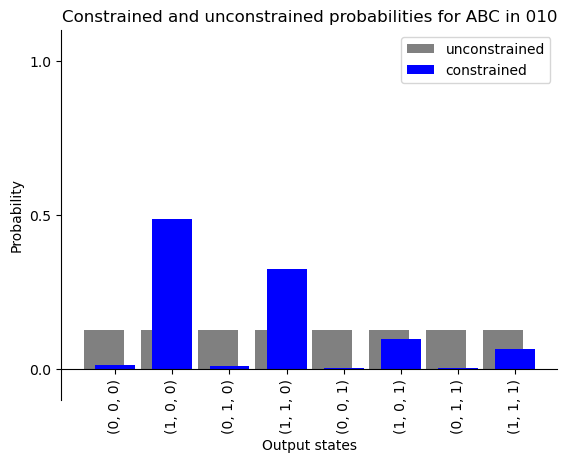

In [28]:
viz.repertoires(substrate,input_state);


As you can see, the probability of the different output states seem to be different in for the constrained and unconstrained probabilities. 

What would the repertoires look like for other input states? And what does it mean for the constrained probability to be higher (or lower) than the unconstrained probability?

---


## 4) How to compute causal informativeness

Informativeness is a the measure we use in IIT to quantify whether there is any causal power in a substrate transition. That is, whether the input state *makes a difference* to the output state, or whether the output state *takes a difference* from the input state.

Informativeness is quantified by the log-ratio of the constrained and unconstrained probabilities characterizing the transition. That is, informativeness is the relative difference that knowing the input state makes to the probability of having the output state occur. 

In [29]:
# pick input and output states for a transition
input_state = (0,1,0)
output_state = (0,1,1)

# obtain constrained and unconstrained probabilities for the output state
P_constrained = utils.constrained_probability(substrate,output_state,input_state)
P_unconstrained = utils.unconstrained_probability(substrate,output_state)

# compute informativeness
informativeness = np.log2(P_constrained/P_unconstrained)

print('The informativeness of input state {} about output state {} is quantified as {}.'.format(input_state, output_state, informativeness))

The informativeness of input state (0, 1, 0) about output state (0, 1, 1) is quantified as -6.123420340811137.


Here, we have made a little function that returns the informativeness for every transition in a "Transition informativeness matrix", so that we easily can inspect the value of infomativeness for every possible transition

In [30]:
TIM = utils.transition_informativeness_matrix(substrate)
viz.transition_informativeness_matrix(substrate)

,,A,0,1,0,1,0,1,0,1
,,B,0,0,1,1,0,0,1,1
,,C,0,0,0,0,1,1,1,1
A,B,C,,,,,,,,
0,0,0,0.44,-2.44,2.17,-0.71,-1.87,-4.75,-0.14,-3.02
1,0,0,-7.85,-13.04,1.96,-3.23,-7.85,-13.04,1.96,-3.23
0,1,0,-3.24,1.96,-3.82,1.38,-5.55,-0.35,-6.12,-0.93
1,1,0,-8.58,-5.69,-1.08,1.81,-8.58,-5.69,-1.08,1.81
0,0,1,1.81,-1.08,-5.69,-8.58,1.81,-1.08,-5.69,-8.58
1,0,1,-0.93,-6.12,-0.35,-5.55,1.38,-3.82,1.96,-3.24
0,1,1,-3.23,1.96,-13.04,-7.85,-3.23,1.96,-13.04,-7.85


From this we can say that there are several transitions (all non-black fields) where the input is informative of the output. 
That is, from the extrinsic point of view, it seems like two input states makes a positive difference to every output state, and every output state takes a positive difference from two input states.
Any input state that is less likely to bring about an output state (constrained P) than that output state is to come about by chance (unconstrained P) has negative informativeness, and is not informative about the output state. 

Which transitions seem to have cause or effect power for this particular substrate?

---


## 5) how we can use the causal informativeness to assess existence in its most basic form?

In our latest publication, we write the following:
> Physical existence can be understood as cause–effect power and it requires the capacity to both take and make a difference. The TPM gives us a complete description of the system in terms of interventional conditional probabilities. On this basis cause–effect power can be measured as causal informativeness: how much a potential cause increases the probability of the current state, and effect informativeness how much the current state increases the probability of a potential effect (as compared to chance).

In other words, it is quite explicit that a substrate in a state only exists physically if it *both* makes and takes a difference. Recall (or check) that the subtrate we are analyzing here actually was in state (OFF, ON ON). We are now ready to ask whether this substrate (aBC) satisfies existence. To do so, its state must both be informative about some output state, and some input state must be informative about *it*. 

In [31]:
# choose a current state of the substrate
current_state = (0,1,1)

# compute the potential cause and effect states (ones that take a difference
# from, and make a difference, to the current substrate state)
potential_causes = utils.potential_causes(substrate, current_state)
potential_effects = utils.potential_effects(substrate, current_state)

# visualize the states in the matrix
viz.highlight_potential_causes_and_effects(
    TIM, current_state, potential_causes, potential_effects
)

,,A,0,1,0,1,0,1,0,1
,,B,0,0,1,1,0,0,1,1
,,C,0,0,0,0,1,1,1,1
A,B,C,,,,,,,,
0,0,0,0.440499,-2.444892,2.171733,-0.713657,-1.867814,-4.753204,-0.136579,-3.021970
1,0,0,-7.850823,-13.044525,1.959503,-3.234199,-7.850823,-13.044525,1.959503,-3.234199
0,1,0,-3.238030,1.955672,-3.815108,1.378594,-5.546342,-0.352640,-6.123420,-0.929718
1,1,0,-8.578460,-5.693069,-1.076445,1.808945,-8.578460,-5.693069,-1.076445,1.808945
0,0,1,1.808945,-1.076445,-5.693069,-8.578460,1.808945,-1.076445,-5.693069,-8.578460
1,0,1,-0.929718,-6.123420,-0.352640,-5.546342,1.378594,-3.815108,1.955672,-3.238030
0,1,1,-3.234199,1.959503,-13.044525,-7.850823,-3.234199,1.959503,-13.044525,-7.850823


Here you can see that the only two output states the current state is informative about (its only potential effects, the only states it makes a difference to) are (1,0,0) and (1,0,1).
Likewise, the only two input states that is informative about the current state (its only potential causes, the only states that it takes a difference from) are also (1,0,0) and (1,0,1).

This symmetry is an accidental property of the substrate, and can be traced back to the symmetric activation function, and the lack of asymmetry between ON and OFF---it is *not* a property we should expect to see in real world systems. 

---
# In conclusion
The substrate in its current state passes the minimal requirement of physical existence. It does make a difference to at least one potential effect state, and it takes a difference from at least one potential cause state. 

This is just the first step, and we can now move on to see if there are any systems in the substrates that do not only exist physically, but does so in an intrinsic manner. See you in the next one!

In [4]:
utils.assess_existence(substrate)


The substrate ABC satisfies existence! 
Its units can both take and make a difference.
